Electric energy consumption prediction using LSTM ML
Appliances energy prediction dataset from UCI Machine Learning Repository
https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv

What is the dataset about?
This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) 
between December 2006 and November 2010 (47 months).
Notes:
(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active 
energy consumed every minute (in watt hour) in the household by electrical equipment not measured in 
sub-meterings 1, 2 and 3.

The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All 
calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.


Attribute Information:

1.date: Date in format dd/mm/yyyy
2.time: time in format hh:mm:ss
3.global_active_power: household global minute-averaged active power (in kilowatt)
4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5.voltage: minute-averaged voltage (in volt)
6.global_intensity: household global minute-averaged current intensity (in ampere)
7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [2]:
# load all data
df=pd.read_csv('../Resources/data/household_power_consumption.txt', delimiter=';')
df.head(5)
df.shape

(2075259, 9)

In [3]:
df.head(5)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [4]:
# Drop null values, 25979 values are null (1.25% of dataset)
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna(subset=['Global_active_power'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print(df.shape)
print(df.date_time.min())
print(df.date_time.max())
df.tail(5)

(2049280, 7)
2006-12-16 17:24:00
2010-12-11 23:59:00


,date_time,Global_active_power,year,quarter,month,day,weekday
2049275,2010-12-11 23:55:00,0.6900,2010,4,12,11,0
2049276,2010-12-11 23:56:00,0.6880,2010,4,12,11,0
2049277,2010-12-11 23:57:00,0.6880,2010,4,12,11,0
2049278,2010-12-11 23:58:00,0.6880,2010,4,12,11,0
2049279,2010-12-11 23:59:00,0.6880,2010,4,12,11,0


In [6]:
# Look at DataFrame
df.head(10)

,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0
5,2006-12-16 17:29:00,3.5200,2006,4,12,16,0
6,2006-12-16 17:30:00,3.7020,2006,4,12,16,0
7,2006-12-16 17:31:00,3.7000,2006,4,12,16,0
8,2006-12-16 17:32:00,3.6680,2006,4,12,16,0
9,2006-12-16 17:33:00,3.6620,2006,4,12,16,0


In [7]:
# Check for null values
df.isnull().sum()

date_time              0
Global_active_power    0
year                   0
quarter                0
month                  0
day                    0
weekday                0
dtype: int64

In [8]:
df.columns

Index(['date_time', 'Global_active_power', 'year', 'quarter', 'month', 'day',
       'weekday'],
      dtype='object')

In [9]:
# Ending date
df.tail(1)

,date_time,Global_active_power,year,quarter,month,day,weekday
2049279,2010-12-11 23:59:00,0.6880,2010,4,12,11,0


In [10]:
# Beginning date
df.head(1)

,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0


In [11]:
df.describe()

,Global_active_power,year,quarter,month,day,weekday
count,2049280.0000,2049280.0000,2049280.0000,2049280.0000,2049280.0000,2049280.0000
mean,1.0916,2008.4248,2.5019,6.4980,15.6689,0.7168
std,1.0573,1.1244,1.1179,3.4460,8.8383,0.4505
min,0.0760,2006.0000,1.0000,1.0000,1.0000,0.0000
25%,0.3080,2007.0000,2.0000,4.0000,8.0000,0.0000
50%,0.6020,2008.0000,3.0000,7.0000,16.0000,1.0000
75%,1.5280,2009.0000,4.0000,10.0000,23.0000,1.0000
max,11.1220,2010.0000,4.0000,12.0000,31.0000,1.0000


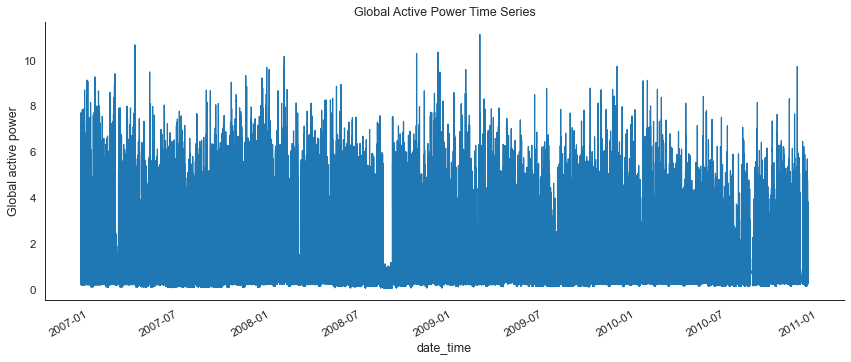

In [12]:
df1=df.loc[:,['date_time','Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0000,1.0916,1.0573,0.0760,0.3080,0.6020,1.5280,11.1220


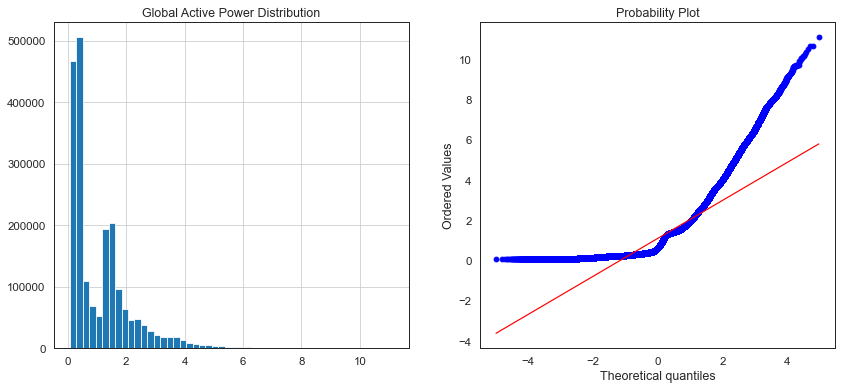

In [13]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'], plot=plt);
df1.describe().T

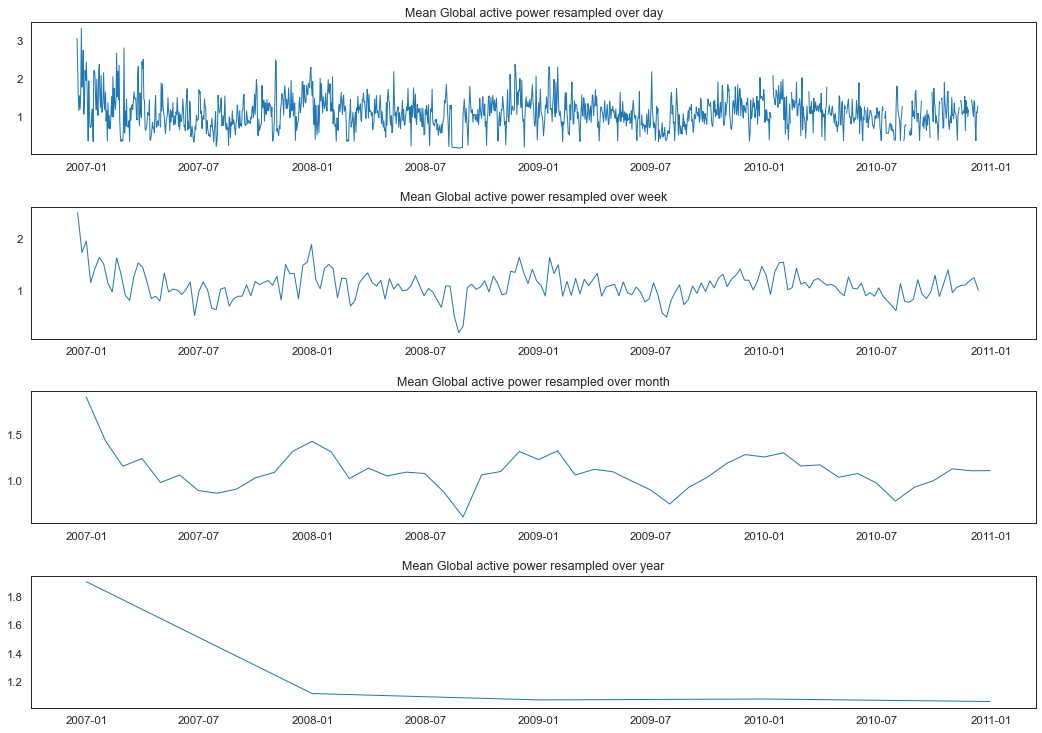

In [14]:
# Average Global Power resampled over day, week, month, year
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over year')
ax4.tick_params(axis='both', which='major');

In [15]:
#LSTM
#The task here will be to predict values for a timeseries given the history of 
# 2 million minutes of a household's power consumption. We are going to use a multi-layered 
# LSTM recurrent neural network to predict the last value of a sequence of values.
# If you want to reduce the computation time, and also get a quick result to test the
# model, you may want to resample the data over hour. I will keep it is in minutes.
# 
#Create dataset, normalize the dataset, split into training and test sets, 
# convert an array of values into a dataset matrix

In [16]:
dataset = df.Global_active_power.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [18]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [19]:
X_train.shape

(1639393, 30)

In [20]:
Y_train.shape

(1639393,)

In [21]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [22]:
# Model Architectue

In [23]:
X_train.shape

(1639393, 1, 30)

In [24]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Epoch 1/20
23420/23420 [==============================] - 68s 3ms/step - loss: 7.7625e-04 - val_loss: 4.4098e-04
Epoch 2/20
23420/23420 [==============================] - 74s 3ms/step - loss: 6.6582e-04 - val_loss: 4.5134e-04
Epoch 3/20
23420/23420 [==============================] - 77s 3ms/step - loss: 6.5321e-04 - val_loss: 4.5165e-04
Epoch 4/20
23420/23420 [==============================] - 75s 3ms/step - loss: 6.4668e-04 - val_loss: 4.4095e-04
Epoch 5/20
23420/23420 [==============================] - 75s 3ms/step - loss: 6.4352e-04 - val_loss: 4.3873e-04
Epoch 6/20
23420/23420 [==============================] - 74s 3ms/step - loss: 6.4093e-04 - val_loss: 4.3461e-04
Epoch 7/20
23420/23420 [==============================] - 86s 4ms/step - loss: 6.3821e-04 - val_loss: 4.2490e-04
Epoch 8/20
23420/23420 [==============================] - 102s 4ms/step - loss: 6.3411e-04 - val_loss: 4.3731e-04
Epoch 9/20
23420/23420 [==============================] - 84s 4ms/step - loss: 6.3321e-04 - val

In [32]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
#train_predict = scaler.inverse_transform(train_predict)
#Y_train = scaler.inverse_transform([Y_train])
#test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 1.008120040267889
Train Root Mean Squared Error: 1.41757028905449
Test Mean Absolute Error: 0.945161784410947
Test Root Mean Squared Error: 1.2613749131270104


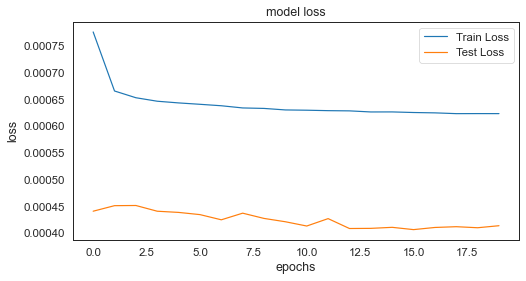

In [33]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

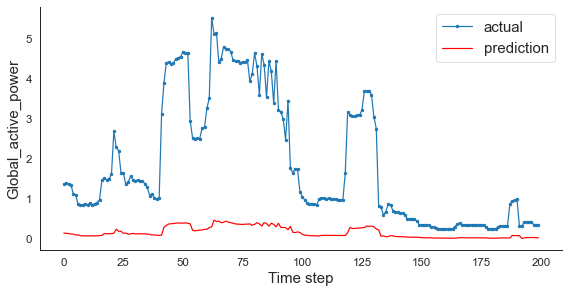

In [34]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [38]:
import tensorflow as tf
train_predict = scaler.inverse_transform(train_predict)
#Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform([Y_test])

predictions = model.predict(X_test)
conf_matrix = tf.math.confusion_matrix(labels=Y_test,
                                       predictions=predictions)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [1,409825] != values[1].shape = [409825,1] [Op:Pack] name: stack

In [ ]:
print('Confusion_matrix: ',conf_matrix)